In [73]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping

In [2]:
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
print(diabetes_dataset.keys())

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
data = diabetes_dataset['data']
targets = diabetes_dataset['target']
targets = (targets - targets.mean(axis=0)) / targets.std()

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape, test_data.shape, train_targets.shape, test_targets.shape)

(397, 10) (45, 10) (397,) (45,)


In [30]:
class Loss_and_Metrics_Callback(Callback):
  def on_train_batch_end(self, batch, logs=None): # this is a function of the Callback class that we can override
    if batch % 2 == 0:
      print('After batch {}, the loss is {:7.2f}'.format(batch, logs['loss']))

  def on_test_batch_end(self, batch, logs=None):
    print('After batch {}, the loss is {:7.2f}'.format(batch, logs['loss']))
  
  def on_epoch_end(self, epoch, logs=None):
    print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}'.format(epoch, logs['loss'], logs['mae']))

  def on_predict_batch_end(self, batch, logs=None):
    print('Finished predictionon batch {}'.format(batch))

In [62]:
lr_schedule = [(4, 0.03), (7, 0.02), (11, 0.005), (15, 0.007)]

def get_new_epoch_lr(epoch, lr):
  epoch_in_sched = [i for i in range(len(lr_schedule)) if lr_schedule[i][0]==int(epoch)]
  if len(epoch_in_sched) > 0:
    return lr_schedule[epoch_in_sched[0]][1]
  else:
    return lr

In [68]:
class LRScheduler(Callback):
  def __init__(self, new_lr):
    super(LRScheduler, self).__init__()
    self.new_lr = new_lr

  def on_epoch_begin(self, epoch, logs=None):
    if not hasattr(self.model.optimizer, 'lr'):
      raise ValueError('Error: Optimizer does not have a learning rate')
      
    curr_rate = float(keras.backend.get_value(self.model.optimizer.lr))

    scheduled_rate = self.new_lr(epoch, curr_rate)

    keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
    print('Learning rate for epoch {} is {:7.4f}'.format(epoch, scheduled_rate))

In [69]:
def get_regularized_model(wd, rate):
  model = Sequential([
                      Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(wd), input_shape=(train_data.shape[1],)),
                      BatchNormalization(),
                      Dropout(rate),
                      Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(wd)),
                      BatchNormalization(),
                      Dropout(rate),
                      Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(wd)),
                      BatchNormalization(),
                      Dropout(rate),
                      Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(wd)),
                      BatchNormalization(),
                      Dropout(rate),
                      Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(wd)),
                      BatchNormalization(),
                      Dropout(rate),
                      Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(wd)),
                      Dense(1)
  ])
  return model

In [104]:
model = get_regularized_model(1e-5, 0.3)

In [105]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [106]:
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=100, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)])

Epoch 1/100
4/4 [==============================] - 4s 267ms/step - loss: 4.0944 - mae: 1.6911 - val_loss: 0.8820 - val_mae: 0.8062
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 2.4134 - mae: 1.2917 - val_loss: 0.8771 - val_mae: 0.7971
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 1.7558 - mae: 1.0928 - val_loss: 0.8783 - val_mae: 0.7875
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 1.4493 - mae: 0.9851 - val_loss: 0.8876 - val_mae: 0.7800
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 1.1925 - mae: 0.8696 - val_loss: 0.9070 - val_mae: 0.7747
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 1.0550 - mae: 0.8275 - val_loss: 0.9364 - val_mae: 0.7720
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 1.1986 - mae: 0.8859 - val_loss: 0.9692 - val_mae: 0.7721
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 1.0327 - mae: 0.8

In [85]:
model.evaluate(test_data, test_targets, verbose=2, callbacks=[])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
2/2 - 0s - loss: 0.7422 - mae: 0.7679
Finished Testing!


[0.7421993017196655, 0.7678905725479126]

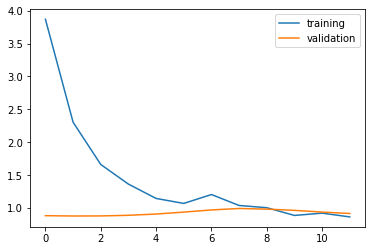

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])

In [39]:
model.predict(test_data, batch_size=10, callbacks=[Loss_and_Metrics_Callback()])

Finished predictionon batch 0
Finished predictionon batch 1
Finished predictionon batch 2
Finished predictionon batch 3
Finished predictionon batch 4


array([[-0.07499625],
       [-0.07793669],
       [-0.08169106],
       [-0.07824877],
       [-0.0798884 ],
       [-0.0759501 ],
       [-0.08181573],
       [-0.07801466],
       [-0.07567702],
       [-0.08124746],
       [-0.0798767 ],
       [-0.07971242],
       [-0.08072646],
       [-0.07879578],
       [-0.08154443],
       [-0.0794965 ],
       [-0.07589374],
       [-0.07504401],
       [-0.07946312],
       [-0.07521836],
       [-0.07938445],
       [-0.0809579 ],
       [-0.07897516],
       [-0.07806223],
       [-0.08119541],
       [-0.08330205],
       [-0.07818477],
       [-0.08191806],
       [-0.0757909 ],
       [-0.08205901],
       [-0.07984701],
       [-0.07968834],
       [-0.0794331 ],
       [-0.07996684],
       [-0.0804445 ],
       [-0.07830865],
       [-0.08181486],
       [-0.07953428],
       [-0.08207611],
       [-0.07989369],
       [-0.07836906],
       [-0.08083384],
       [-0.07903962],
       [-0.07593986],
       [-0.07790829]], dtype=flo